# Set Parameter
- Attention = True
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 32
- Learning rate = 0.001
- Hidden unit = 200
- Epochs = 100
- N = 100
- Data Length = 100K
- Data = [single_Ctype4_error_rate]
- Deduplication
- Random split

# Import packages

import useful packages for experiments

In [1]:
import os
import argparse
import logging
import sys
import json

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

os.chdir(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))))))

from models.trainer import Trainer
from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from dataset import fields

import matplotlib.pyplot as plt

/home/hyeontae/hyeontae/venv1/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/hyeontae/hyeontae/venv1/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


# Log format

In [2]:
log_level = 'info'
LOG_FORMAT = '%(asctime)s %(levelname)-6s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, log_level.upper()))

In [3]:
character_accuracy = []
sentence_accuracy = []
f1_score = []
rnnis = ["lstm", "gru"]

# Prepare dataset

In [ ]:
for rnn in rnnis:
    print("rnn : %s" % rnn)
    train_path = "data/copy_rand/correction_single_Ctype4_error_rate_5/data_train.txt"
    dev_path = "data/copy_rand/correction_single_Ctype4_error_rate_5/data_test.txt"
    config_path = "models/config.json"
    max_len = 104
    src = fields.SourceField()
    tgt = fields.TargetField()
    def len_filter(example):
        return len(example.src) <= max_len and len(example.tgt) <= max_len
    train = torchtext.data.TabularDataset(
        path=train_path, format='tsv',
        fields=[('src', src), ('tgt', tgt)],
        filter_pred=len_filter
    )
    dev = torchtext.data.TabularDataset(
        path=dev_path, format='tsv',
        fields=[('src', src), ('tgt', tgt)],
        filter_pred=len_filter
    )
    src.build_vocab(train)
    tgt.build_vocab(train)
    input_vocab = src.vocab
    output_vocab = tgt.vocab

    weight = torch.ones(len(tgt.vocab))
    pad = tgt.vocab.stoi[tgt.pad_token]
    loss = Perplexity(weight, pad)
    if torch.cuda.is_available():
        loss.cuda()
        
    '''
    {
        "max_len": 102,
        "embedding_size": 5,
        "hidden_size": 200,
        "input_dropout_p": 0,
        "dropout_p": 0,
        "n_layers": 1,
        "bidirectional": false,
        "rnn_cell": "lstm",
        "variable_lengths": false,
        "embedding": null,
        "update_embedding": true,
        "get_context_vector": false,
        "use_attention": true,
        "attn_layers": 1,
        "hard_attn": false,
        "position_embedding": null
    }

    '''

    optimizer = "Adam"
    seq2seq = None
    config_json = open(config_path).read()
    config = json.loads(config_json)
    config["max_len"] = max_len
    config["rnn_cell"] = rnn
    config["hard_attn"] = True
    config["position_embedding"] = None
    
    print("Train_path : %s" % train_path)
    print("Dev_path = %s" % dev_path)
    print(json.dumps(config, indent=4))
    seq2seq = Seq2seq(config, len(src.vocab), len(tgt.vocab), tgt.sos_id, tgt.eos_id)
    
    if torch.cuda.is_available():
        seq2seq.cuda()

    for param in seq2seq.parameters():
        param.data.uniform_(-0.08, 0.08)

    # train
    t = Trainer(loss=loss, batch_size=32,
                checkpoint_every=50,
                print_every=100,
                hidden_size=config["hidden_size"],
                path="copy_rand_error_rate_5_hard_attn",
                file_name=config["rnn_cell"])

    seq2seq, ave_loss, character_accuracy_list, sentence_accuracy_list, f1_score_list = t.train(seq2seq, train,
                                                                             num_epochs=100, dev_data=dev,
                                                                             optimizer=optimizer,
                                                                             teacher_forcing_ratio=0.5)

    character_accuracy.append(character_accuracy_list)
    sentence_accuracy.append(sentence_accuracy_list)
    f1_score.append(f1_score_list)

rnn : lstm


/home/hyeontae/hyeontae/venv1/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
2019-08-19 02:19:41,644 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Train_path : data/copy_rand/correction_single_Ctype4_error_rate_5/data_train.txt
Dev_path = data/copy_rand/correction_single_Ctype4_error_rate_5/data_test.txt
{
    "max_len": 104,
    "embedding_size": 5,
    "hidden_size": 200,
    "input_dropout_p": 0,
    "dropout_p": 0,
    "n_layers": 1,
    "bidirectional": false,
    "rnn_cell": "lstm",
    "variable_lengths": false,
    "embedding": null,
    "update_embedding": true,
    "get_context_vector": false,
    "use_attention": true,
    "attn_layers": 1,
    "hard_attn": true,
    "position_embedding": null
}


/home/hyeontae/hyeontae/venv1/lib/python3.6/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
2019-08-19 02:23:35,958 INFO   Finished epoch 1: Train loss: 1.6235, Dev loss: 1.3322, Accuracy(character): 0.9264, Accuracy(sentence): 0.2633, F1 Score: 0.0440
2019-08-19 02:27:28,069 INFO   Finished epoch 2: Train loss: 1.4282, Dev loss: 1.1327, Accuracy(character): 0.9708, Accuracy(sentence): 0.7221, F1 Score: 0.7484
2019-08-19 02:31:27,779 INFO   Finished epoch 3: Train loss: 3.0934, Dev loss: 1.1350, Accuracy(character): 0.9697, Accuracy(sentence): 0.7265, F1 Score: 0.7489
2019-08-19 02:35:24,794 INFO   Finished epoch 4: Train loss: 3.7040, Dev loss: 1.1465, Accuracy(character): 0.9698, Accuracy(sentence): 0.7698, F1 Score: 0.7593
2019-08-19 02:39:20,507 INFO   Finished epoch 5: Train loss: 3.2504, Dev loss: 2.8575, Accuracy(character): 0.8590, Accur

In [ ]:
for rnn in rnnis:
    print("rnn : %s" % rnn)
    train_path = "data/copy_rand/correction_single_Ctype4_error_rate_5/data_train.txt"
    dev_path = "data/copy_rand/correction_single_Ctype4_error_rate_5/data_test.txt"
    config_path = "models/config.json"
    max_len = 104
    src = fields.SourceField()
    tgt = fields.TargetField()
    def len_filter(example):
        return len(example.src) <= max_len and len(example.tgt) <= max_len
    train = torchtext.data.TabularDataset(
        path=train_path, format='tsv',
        fields=[('src', src), ('tgt', tgt)],
        filter_pred=len_filter
    )
    dev = torchtext.data.TabularDataset(
        path=dev_path, format='tsv',
        fields=[('src', src), ('tgt', tgt)],
        filter_pred=len_filter
    )
    src.build_vocab(train)
    tgt.build_vocab(train)
    input_vocab = src.vocab
    output_vocab = tgt.vocab

    weight = torch.ones(len(tgt.vocab))
    pad = tgt.vocab.stoi[tgt.pad_token]
    loss = Perplexity(weight, pad)
    if torch.cuda.is_available():
        loss.cuda()
        
    '''
    {
        "max_len": 102,
        "embedding_size": 5,
        "hidden_size": 200,
        "input_dropout_p": 0,
        "dropout_p": 0,
        "n_layers": 1,
        "bidirectional": false,
        "rnn_cell": "lstm",
        "variable_lengths": false,
        "embedding": null,
        "update_embedding": true,
        "get_context_vector": false,
        "use_attention": true,
        "attn_layers": 1,
        "hard_attn": false,
        "position_embedding": null
    }

    '''

    optimizer = "Adam"
    seq2seq = None
    config_json = open(config_path).read()
    config = json.loads(config_json)
    config["max_len"] = max_len
    config["rnn_cell"] = rnn
    config["hard_attn"] = True
    config["position_embedding"] = "length"
    
    print("Train_path : %s" % train_path)
    print("Dev_path = %s" % dev_path)
    print(json.dumps(config, indent=4))
    seq2seq = Seq2seq(config, len(src.vocab), len(tgt.vocab), tgt.sos_id, tgt.eos_id)
    
    if torch.cuda.is_available():
        seq2seq.cuda()

    for param in seq2seq.parameters():
        param.data.uniform_(-0.08, 0.08)

    # train
    t = Trainer(loss=loss, batch_size=32,
                checkpoint_every=50,
                print_every=100,
                hidden_size=config["hidden_size"],
                path="copy_rand_error_rate_5_hard_attn",
                file_name=config["rnn_cell"] + "_lenemb")

    seq2seq, ave_loss, character_accuracy_list, sentence_accuracy_list, f1_score_list = t.train(seq2seq, train,
                                                                             num_epochs=100, dev_data=dev,
                                                                             optimizer=optimizer,
                                                                             teacher_forcing_ratio=0.5)

    character_accuracy.append(character_accuracy_list)
    sentence_accuracy.append(sentence_accuracy_list)
    f1_score.append(f1_score_list)

rnn : lstm


2019-08-19 15:17:54,279 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Train_path : data/copy_rand/correction_single_Ctype4_error_rate_5/data_train.txt
Dev_path = data/copy_rand/correction_single_Ctype4_error_rate_5/data_test.txt
{
    "max_len": 104,
    "embedding_size": 5,
    "hidden_size": 200,
    "input_dropout_p": 0,
    "dropout_p": 0,
    "n_layers": 1,
    "bidirectional": false,
    "rnn_cell": "lstm",
    "variable_lengths": false,
    "embedding": null,
    "update_embedding": true,
    "get_context_vector": false,
    "use_attention": true,
    "attn_layers": 1,
    "hard_attn": true,
    "position_embedding": "length"
}


2019-08-19 15:22:10,158 INFO   Finished epoch 1: Train loss: 1.5079, Dev loss: 1.2457, Accuracy(character): 0.9366, Accuracy(sentence): 0.3146, F1 Score: 0.2439
2019-08-19 15:26:27,267 INFO   Finished epoch 2: Train loss: 1.4653, Dev loss: 1.5432, Accuracy(character): 0.8922, Accuracy(sentence): 0.3390, F1 Score: 0.3127
2019-08-19 15:30:36,666 INFO   Finished epoch 3: Train loss: 2.7136, Dev loss: 1.4452, Accuracy(character): 0.9234, Accuracy(sentence): 0.2242, F1 Score: 0.0474
2019-08-19 15:34:24,737 INFO   Finished epoch 4: Train loss: 3.4961, Dev loss: 1.1362, Accuracy(character): 0.9707, Accuracy(sentence): 0.8663, F1 Score: 0.8112
2019-08-19 15:38:11,678 INFO   Finished epoch 5: Train loss: 4.2433, Dev loss: 1.1118, Accuracy(character): 0.9680, Accuracy(sentence): 0.8285, F1 Score: 0.7857
2019-08-19 15:42:01,340 INFO   Finished epoch 6: Train loss: 3.6237, Dev loss: 1.0318, Accuracy(character): 0.9938, Accuracy(sentence): 0.9353, F1 Score: 0.9553
2019-08-19 15:45:47,819 INFO   Fin

2019-08-19 18:43:02,680 INFO   Finished epoch 52: Train loss: 1.5543, Dev loss: 1.0002, Accuracy(character): 1.0000, Accuracy(sentence): 0.9992, F1 Score: 0.9998
2019-08-19 18:47:05,091 INFO   Finished epoch 53: Train loss: 1.6557, Dev loss: 1.0000, Accuracy(character): 1.0000, Accuracy(sentence): 0.9998, F1 Score: 0.9999
2019-08-19 18:51:07,891 INFO   Finished epoch 54: Train loss: 1.4980, Dev loss: 1.3795, Accuracy(character): 0.9545, Accuracy(sentence): 0.7273, F1 Score: 0.6771
2019-08-19 18:54:50,892 INFO   Finished epoch 55: Train loss: 2.2455, Dev loss: 1.0038, Accuracy(character): 0.9994, Accuracy(sentence): 0.9932, F1 Score: 0.9959
2019-08-19 18:58:37,087 INFO   Finished epoch 56: Train loss: 1.5481, Dev loss: 1.0028, Accuracy(character): 0.9996, Accuracy(sentence): 0.9963, F1 Score: 0.9969
2019-08-19 19:02:17,621 INFO   Finished epoch 57: Train loss: 1.3385, Dev loss: 1.0010, Accuracy(character): 0.9999, Accuracy(sentence): 0.9977, F1 Score: 0.9991
2019-08-19 19:06:22,297 INFO

(0, 1)

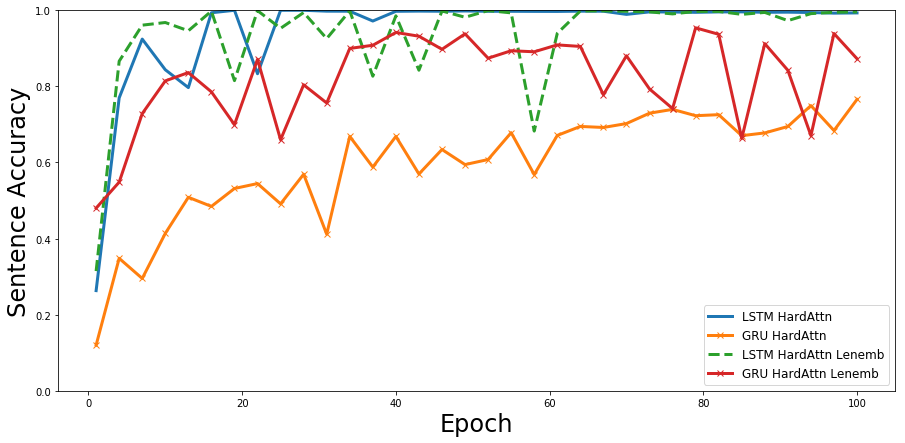

In [17]:
epochs = list(range(1, 101, 1))
plt.figure(figsize=(15,7))
plt.plot(epochs[::3], sentence_accuracy[0][::3], '-', LineWidth=3, label="LSTM HardAttn")
plt.plot(epochs[::3], sentence_accuracy[1][::3], '-x', LineWidth=3, label="GRU HardAttn")
plt.plot(epochs[::3], sentence_accuracy[2][::3], '--', LineWidth=3, label="LSTM HardAttn Lenemb")
plt.plot(epochs[::3], sentence_accuracy[3][::3], '-x', LineWidth=3, label="GRU HardAttn Lenemb")

plt.legend(loc="best", fontsize=12)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Sentence Accuracy', fontsize=24)
plt.ylim([0, 1])
#plt.savefig('../../../log/plot/gru_palindrome_rand_correction_ctype4_lenemb_add_order_encoder_decoder/ctype_to_sentence_accuracy.png')

(0, 1.02)

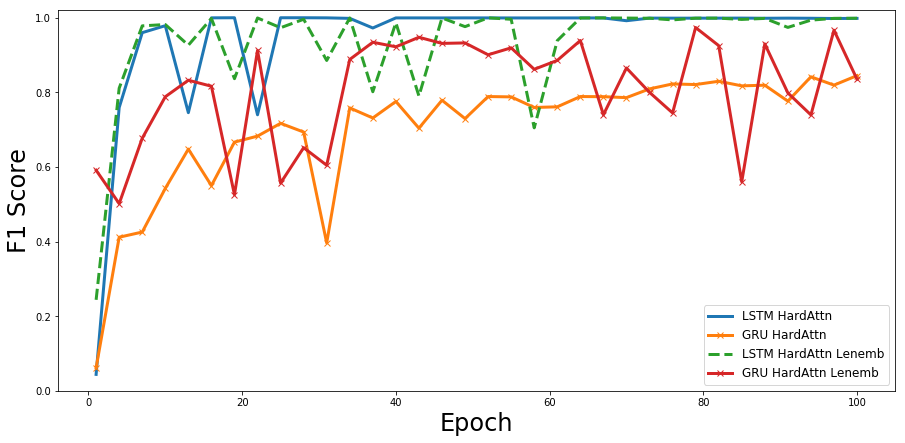

In [25]:
plt.figure(figsize=(15,7))
plt.plot(epochs[::3], f1_score[0][::3], '-', LineWidth=3, label="LSTM HardAttn")
plt.plot(epochs[::3], f1_score[1][::3], '-x', LineWidth=3, label="GRU HardAttn")
plt.plot(epochs[::3], f1_score[2][::3], '--', LineWidth=3, label="LSTM HardAttn Lenemb")
plt.plot(epochs[::3], f1_score[3][::3], '-x', LineWidth=3, label="GRU HardAttn Lenemb")
plt.legend(loc="best", fontsize=12)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('F1 Score', fontsize=24)
plt.ylim([0, 1.02])
#plt.savefig('../../../log/plot/gru_palindrome_rand_correction_ctype4_lenemb_add_order_encoder_decoder/ctype_to_f1_score.png')

In [19]:
error_rate_list = []
for i in range(len(character_accuracy)):
    error_rate = []
    for j in character_accuracy[i]:
        error_rate.append(1 - j)
    error_rate_list.append(error_rate)

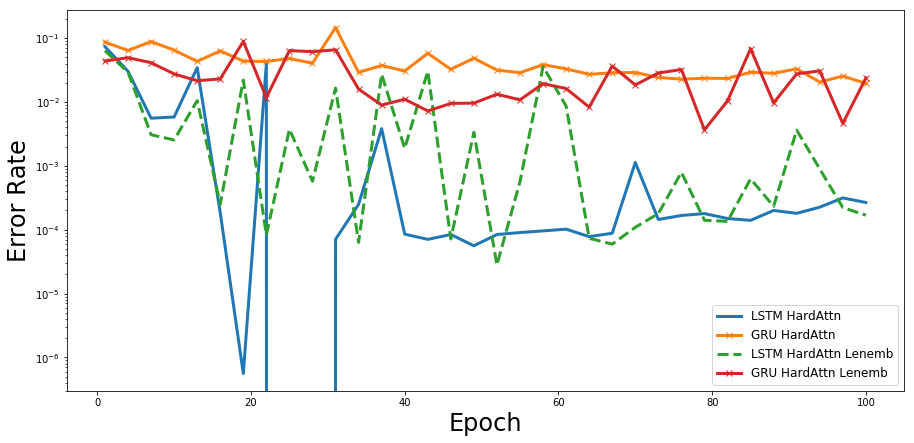

In [20]:
epochs = list(range(1, 101, 1))
plt.figure(figsize=(15,7))
plt.plot(epochs[::3], error_rate_list[0][::3], '-', LineWidth=3, label="LSTM HardAttn")
plt.plot(epochs[::3], error_rate_list[1][::3], '-x', LineWidth=3, label="GRU HardAttn")
plt.plot(epochs[::3], error_rate_list[2][::3], '--', LineWidth=3, label="LSTM HardAttn Lenemb")
plt.plot(epochs[::3], error_rate_list[3][::3], '-x', LineWidth=3, label="GRU HardAttn Lenemb")
plt.legend(loc="best", fontsize=12)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Error Rate', fontsize=24)
plt.yscale('log')
#plt.ylim([0, 1])
#plt.savefig('../../../log/plot/gru_palindrome_rand_correction_ctype4_lenemb_add_order_encoder_decoder/ctype_to_error_rate.png')

In [21]:
print(len(character_accuracy))
for i in character_accuracy:
    print(i)

4
[0.9264095627753403, 0.9707612177330355, 0.9696923815419953, 0.9697764977165263, 0.8590465263384566, 0.9942907548473348, 0.9944264622755781, 0.9270393125353288, 0.9569947646092972, 0.9941830861439351, 0.9979565377333943, 0.9150073349304191, 0.9655146115402905, 0.9997353144374759, 0.9898236252052435, 0.9998155051905288, 0.9999943922550313, 0.9999971961275156, 0.9999994392255032, 1.0, 0.8855621876486053, 0.9604844643033387, 0.99999102760805, 0.9944903905682215, 1.0, 1.0, 1.0, 1.0, 0.9999624281087095, 0.9999366324818534, 0.999929342413394, 0.9989177052210348, 0.999765596260307, 0.9997498945743946, 0.9989648102787723, 0.999947287197294, 0.9961788825783066, 0.9999265385409096, 0.9999394363543377, 0.9999147622764752, 0.9996988640951792, 0.9997072757126322, 0.999929342413394, 0.9999299031878909, 0.999893452845594, 0.999915883825469, 0.9999299031878909, 0.9999327070603752, 0.9999439225503127, 0.9999534557167595, 0.9999428010013189, 0.999915883825469, 0.9999214915704377, 0.9999209307959409, 0

In [22]:
print(len(sentence_accuracy))
for i in sentence_accuracy:
    print(i)

4
[0.26328, 0.7221, 0.72652, 0.76984, 0.67744, 0.92804, 0.9243, 0.76528, 0.78082, 0.84372, 0.96482, 0.7458, 0.79682, 0.99372, 0.95822, 0.9935, 0.9998, 0.9999, 0.99998, 1.0, 0.67584, 0.83326, 0.99968, 0.9741, 1.0, 1.0, 1.0, 1.0, 0.99866, 0.99774, 0.99768, 0.99326, 0.99164, 0.99752, 0.9935, 0.99814, 0.97178, 0.99754, 0.99798, 0.9973, 0.99636, 0.98982, 0.99782, 0.99798, 0.9972, 0.99744, 0.99778, 0.99788, 0.9982, 0.99848, 0.99824, 0.99734, 0.99738, 0.99762, 0.99734, 0.99838, 0.99754, 0.99708, 0.99796, 0.99724, 0.99696, 0.99576, 0.99756, 0.99766, 0.99688, 0.99754, 0.99752, 0.99432, 0.99688, 0.98924, 0.99618, 0.99508, 0.99578, 0.99726, 0.99522, 0.99544, 0.9966, 0.99586, 0.99462, 0.99572, 0.99572, 0.9957, 0.99602, 0.99204, 0.99582, 0.99536, 0.9943, 0.99474, 0.99244, 0.98962, 0.99504, 0.99494, 0.99226, 0.99412, 0.99458, 0.99316, 0.99252, 0.99406, 0.99384, 0.99308]
[0.11998, 0.10046, 0.26968, 0.3481, 0.4278, 0.37184, 0.29526, 0.47778, 0.48772, 0.41366, 0.45088, 0.40312, 0.50852, 0.51184, 0.4923

In [23]:
print(len(f1_score))
for i in f1_score:
    print(i)

4
[0.04400348887919756, 0.7483539751138439, 0.7488539271786948, 0.7592938023802643, 0.40039415486254964, 0.9589653611048224, 0.9600280560802785, 0.5852811223637661, 0.6987934684229817, 0.97867056998806, 0.985630791830101, 0.5404506919121623, 0.7455537436331059, 0.9981555702556519, 0.9294120764516386, 0.9997241293561334, 0.9999611396950243, 0.999980569469974, 0.9999961138335866, 1.0, 0.4419511917305009, 0.7398708078426903, 0.9999145013485469, 0.9609590412668094, 1.0, 1.0, 1.0, 1.0, 0.9997940747935891, 0.9996814346319405, 0.99970471446666, 0.9924105864968784, 0.9985334562584851, 0.9983370891289144, 0.9927121735418526, 0.9997785263845015, 0.9725349775819359, 0.9996736292428199, 0.9997163274901978, 0.9995491854246985, 0.9975892014860768, 0.9986762884837098, 0.9995648085546205, 0.9995492134552012, 0.999269244523221, 0.9994793771174588, 0.9995609280349393, 0.9995958685329251, 0.9996424629638265, 0.9997707143995244, 0.9996268772737165, 0.9995568788724511, 0.9996384909914288, 0.999560781265183

In [24]:
print(len(error_rate_list))
for i in error_rate_list:
    print(i)

4
[0.07359043722465974, 0.029238782266964525, 0.03030761845800467, 0.030223502283473702, 0.14095347366154343, 0.005709245152665243, 0.005573537724421929, 0.07296068746467121, 0.04300523539070278, 0.005816913856064865, 0.002043462266605678, 0.08499266506958092, 0.0344853884597095, 0.0002646855625241251, 0.010176374794756526, 0.0001844948094712473, 5.6077449687164105e-06, 2.8038724844137164e-06, 5.607744968383344e-07, 0.0, 0.11443781235139472, 0.03951553569666133, 8.972391949968461e-06, 0.005509609431778473, 0.0, 0.0, 0.0, 0.0, 3.757189129049987e-05, 6.336751814661756e-05, 7.065758660596e-05, 0.0010822947789651538, 0.00023440373969296768, 0.00025010542560544025, 0.0010351897212277361, 5.2712802706023076e-05, 0.003821117421693443, 7.346145909037372e-05, 6.056364566231487e-05, 8.523772352475589e-05, 0.0003011359048208373, 0.0002927242873678182, 7.065758660596e-05, 7.009681210912166e-05, 0.00010654715440594487, 8.41161745309682e-05, 7.009681210912166e-05, 6.729293962481897e-05, 5.6077449687